In [11]:
from fastai.vision.all import *
import torch

import warnings
warnings.filterwarnings('ignore')

# The Data

The data we will use will be from the Oxford-IIT Pets dataset which contains over $200$ images of around $37$ breeds of Dogs and Cats. By the end, our model will hopefully be able to predict the breed of a pet given some image with a sufficiently good accuracy.

In [2]:
# use fastai's data downloading functionality
path = untar_data(URLs.PETS)

In [4]:
# Check what's inside the path
path.ls()

(#2) [Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images')]

Here we do not care about the `annotations` directory, we will jump straight to looking through the actual images.

In [5]:
(path/'images').ls()

(#7393) [Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg')...]

Here we can see that the breeds(that become our labels) are written in the file names themselves so we have no need of parsing through some external csv file or something. Now to think of how to actually extract the labels: we will make use of Regular Expressions.

In forming the pattern to parse for, note that each .jpg file has the following structure: the pet breed, a number and the extension, all seperated with `_`. This is the pattern we will search for using an example.

In [8]:
# Grab a small sample
fname = (path/'images').ls()[0]
fname

Path('C:/Users/Zohaib/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')

In [9]:
# Extract the text from the start to the last underscore before the number
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

Now we have our label extracted from the filename and stored inside a list. Now we can make use of the `DataBlock` API to simplify the process of creating our `DataLoaders` for the model.

Note that when it comes to resizing and augmentations for the images (the preprocessing), we will work to "presize" them: this means resizing the images to be much larger and then composing all the augmentations into a single step to speed things up on the GPU.

In the end we set our images to be squares of size $224$ pixels since they would then be all the same size and can be collated easily into tensors and we pick this specific value since the older pretrained models work off this particular size of image specifically.

In [10]:
# Create the datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter=RandomSplitter(seed=42),
                  get_items=get_image_files,
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))

# Make the dataloaders
dls = dblock.dataloaders(path/"images", bs=32)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


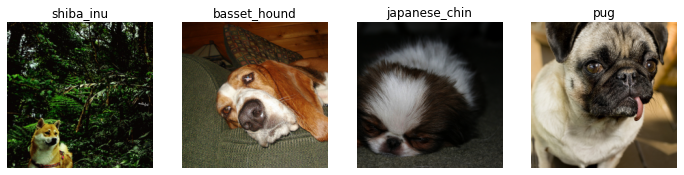

In [12]:
# Just check whether the data was compiled right
dls.show_batch(nrows=1, ncols=4)

# The Baseline

Everything looks nice so far. Now to create a model without any fancy tweaking just to establish a baseline. We will use a `resnet34` architecture and a pretrained model from the ImageNet competition.

In [13]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.023493,0.330034,0.897158,05:37


epoch,train_loss,valid_loss,accuracy,time
0,0.595141,0.314315,0.903924,08:29
1,0.340826,0.222165,0.933018,05:35


## Interpretation

Not bad for a baseline! Our first model already has over a $93$% accuracy on the Validation sets.

We can plot a confusion matrix to see which values the model was the most confused with but this is not a good idea since it will plot a square of $37$ which is difficult to read through. For now, we will just look at those cells with the most incorrect predictions (specifically over four incorrect predictions).

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=4)

[('Birman', 'Ragdoll', 6),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('basset_hound', 'beagle', 4)]

Note that if you actually google images of these breeds, you will see that they are actually rather similar and it makes sense that our model was confusing them multiple times.

# Improving the Model

## The Learning Rate Finder

Perhaps the most important hyperparameter to tune in training Neural Networks is the Learning Rate. We can't have it too small that we give the model ample opportunity to memorize examples and leave it unable to generalize as well- we can't have it too high or the model will overshoot the minimum loss during Gradient Descent.

The Learning Rate finder was proposed by Leslie Smith who basically proposed to start training the model at a rate that was so small it was inconceivable for it to overshoot the minimum- then to increase the learning rate as the training progressed until the calculated loss value for the mini-batches would increase rather than decrease in which case we know that we overshot the minimum. 

We can plot a graph of how the Validation Loss varies as we increase the Learning Rate.

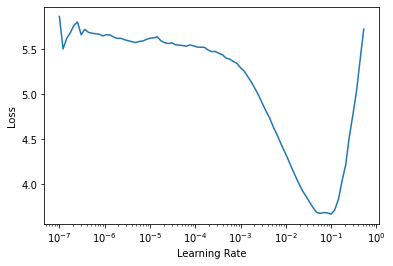

In [15]:
# Create a new model
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Plot
lr_min, lr_steep = learn.lr_find()

In [19]:
print(f"Learning Rate for minimum loss (/10): {lr_min:.2e} \nLearning Rate for steepest decline of Loss: {lr_steep:.2e}")

Learning Rate for minimum loss (/10): 1.00e-02 
Learning Rate for steepest decline of Loss: 4.37e-03


Note that we do not use the learning rate that gives the lowest loss because at that critical point, the model will not be able to learn as much from the data to update the weights; we use the steepest point (or something close to that) instead.

In [20]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.950329,0.303847,0.903248,05:31


epoch,train_loss,valid_loss,accuracy,time
0,0.652580,0.453619,0.857239,05:57
1,0.344472,0.226707,0.927605,05:25


Our model with a specified learning rate did just a little bit worse than the baseline model.

## Unfreezing

In fine-tuning a pretrained model, we leave the earlier layers in the Convolutional Base intact since those already have appropriate weights for learning the basic features in images. When it comes to the Dense Head that we add in ourselves, we randomize the weights to start and optimize them during the fine-tuning process.

We could try to freeze all the initial layers entirely and train the last few linear layers to optimize the random weights alone, for one epoch, then unfreeze everything else and train the model again for as many weights as desired. This differs from the regular approach.

In [21]:
# Instantiate another model
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Train the head while freezing everything else for 3 epochs
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.908115,0.362682,0.878214,04:23
1,0.526221,0.250232,0.924222,04:23
2,0.331423,0.218011,0.930988,04:30


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=7.585775847473997e-07)

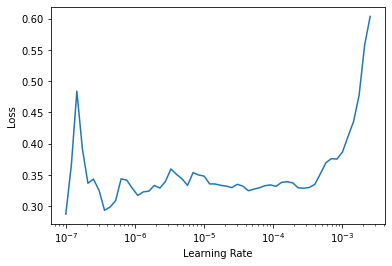

In [22]:
# Unfreeze the model
learn.unfreeze()

# Find an appropriate learning rate
learn.lr_find()

In [23]:
# Train the model again for 5 epochs, allowing the learning rate to vary up to some maximum value
learn.fit_one_cycle(5, lr_max=2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.282271,0.215046,0.936401,05:23
1,0.280345,0.201487,0.933694,04:51
2,0.235665,0.194185,0.944520,05:01
3,0.206062,0.181181,0.948579,05:29
4,0.184963,0.179511,0.946549,05:42


The model definitely showed improved performance simply by giving extra attention to the randomized head first and being a bit stricter with the learning rate.

## Discriminative Learning Rates

Lets try one final thing: since the earlier layers of the pretrained model have likely seen millions of images, it is nonsensical to train them at the same rate as the new Dense Head that we have just randomized; the pretrained base needs little tweaking and hence we should set the learning rates for the later layers to be progressively higher than the earlier layers. Jason Yosinski proposed this idea not too recently.

In [24]:
# Make the final model
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Train the dense head for three epochs 
learn.fit_one_cycle(3, 3e-3)

# Unfreeze to allow all layers to step their weights
learn.unfreeze()

# Have the earliest layer learn at a rate of 1e-6 and the final layer at a rate of 1e-4
# The layers in between have their learning rates step progressively up; this is done for 5 epochs
learn.fit_one_cycle(5, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.870769,0.348057,0.889716,04:25
1,0.540345,0.304876,0.907984,04:41
2,0.340423,0.229422,0.927605,05:13


epoch,train_loss,valid_loss,accuracy,time
0,0.288995,0.224491,0.930988,06:06
1,0.289761,0.211001,0.934371,06:13
2,0.236012,0.200096,0.938430,06:08
3,0.224284,0.201881,0.941813,06:18
4,0.194885,0.201100,0.937077,06:02


Here, we made sure to freeze the pretrained base to focus solely on stepping the weights of the randomized Dense Head; then we unfroze the base and fine-tuned the whole model, making sure to set higher learning rates for the later layers that needed more tweaking as compared to the earlier layers.

Though we did not achieve the best accuracy here, we still improved upon our baseline and an accuracy of $93.7$% for pet-breed classification is still appreciable. In the graph below, it can be seen that the Validation Loss did reach a minimum and that there were no apparent signs of overfitting. 

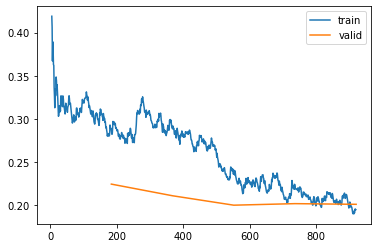

In [25]:
# Make a plot of the training and validation loss
learn.recorder.plot_loss()

In [26]:
# Save the model
learn.export()

In [27]:
# Check if it exists in the directory
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

# fin :)